In [702]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [703]:
# 1.1 Memuat Dataset
df = pd.read_csv("data_final.csv")
print("Dataset dimuat dengan bentuk:", df.shape)

Dataset dimuat dengan bentuk: (1228, 6)


In [704]:
df['Result'] = df['Result'].str.strip().str.title() # Hilangkan spasi & rapikan kapital

In [705]:
print(df['Result'].value_counts())

Result
Ya Dbd       898
Tidak Dbd    330
Name: count, dtype: int64


In [706]:
# 1.2 Cek Missing Value
print("\nCek Missing Value:")
print(df.isnull().sum())


Cek Missing Value:
Platelet       0
WBC            0
Lymphocytes    0
Neutrophils    0
Hemoglobin     0
Result         0
dtype: int64


In [707]:
# Mengecek jumlah data duplikat
print("\nJumlah Duplikasi:", df.duplicated().sum())

# Menampilkan data yang terduplikasi (seluruh baris yang duplikat)
df_duplicated = df[df.duplicated()]
print("\nData Duplikat:")
print(df_duplicated)


Jumlah Duplikasi: 0

Data Duplikat:
Empty DataFrame
Columns: [Platelet, WBC, Lymphocytes, Neutrophils, Hemoglobin, Result]
Index: []


Fitur Platelet: Jumlah outlier = 0
Fitur WBC: Jumlah outlier = 0
Fitur Lymphocytes: Jumlah outlier = 0
Fitur Neutrophils: Jumlah outlier = 13
Fitur Hemoglobin: Jumlah outlier = 1


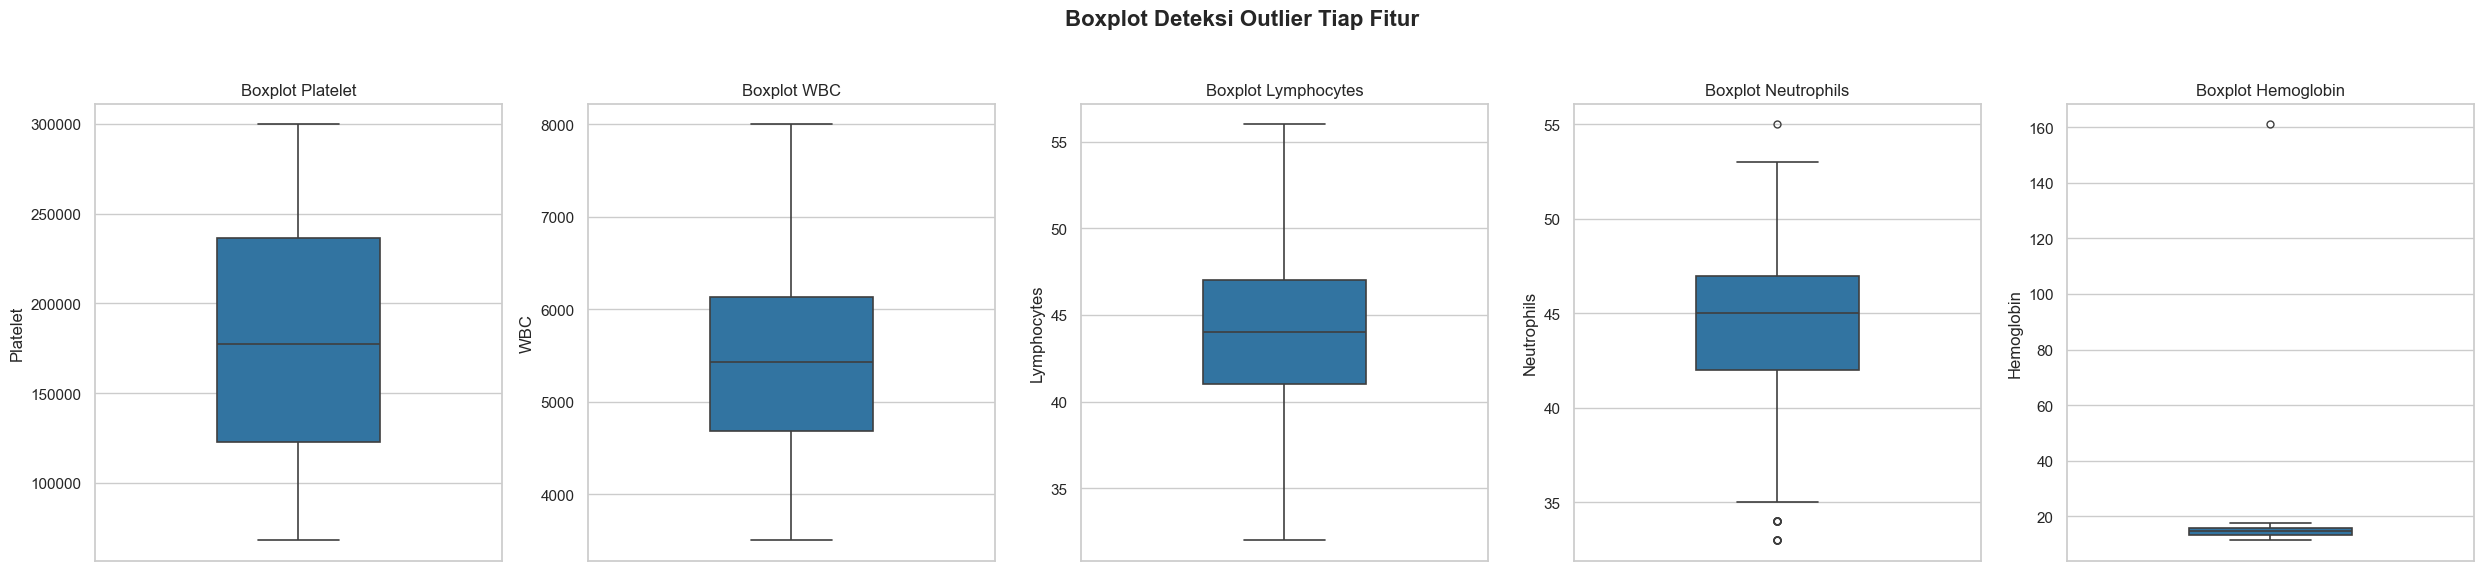

In [710]:
# Fitur yang ingin dianalisis
outlier_features = ['Platelet', 'WBC', 'Lymphocytes', 'Neutrophils', 'Hemoglobin']

# Warna biru kuat
blue_color = '#1f77b4'

# Set style visual
sns.set(style="whitegrid")

# Ukuran dan tata letak plot
fig, axes = plt.subplots(nrows=1, ncols=len(outlier_features), figsize=(5 * len(outlier_features), 6))
fig.suptitle('Boxplot Deteksi Outlier Tiap Fitur', fontsize=16, fontweight='bold')

# === 5. Buat Boxplot dan hitung outlier ===
for i, feature in enumerate(outlier_features):
    ax = axes[i] if len(outlier_features) > 1 else axes  # Support untuk 1 kolom juga
    
    # Hitung IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Hitung jumlah outlier
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outlier_count = outliers.shape[0]
    
    # Tampilkan hasil deteksi outlier di terminal
    print(f'Fitur {feature}: Jumlah outlier = {outlier_count}')

    # Tampilkan boxplot
    sns.boxplot(
        y=df[feature],
        ax=ax,
        color=blue_color,
        fliersize=5,
        linewidth=1.2,
        width=0.4
    )
    ax.set_title(f'Boxplot {feature}')
    ax.set_ylabel(feature)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('boxplot_outlier_fitur_penting.png', dpi=300)
plt.show()

In [711]:
# Fungsi untuk menghapus outlier menggunakan IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"\nFitur: {column}")
    print(f"Batas IQR:")
    print(f"  Lower Bound: {lower_bound}")
    print(f"  Upper Bound: {upper_bound}")

    initial_count = df.shape[0]
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    final_count = df_filtered.shape[0]
    print(f"  Outlier terhapus: {initial_count - final_count}")
    print(f"  Data tersisa: {final_count}")

    return df_filtered

# Fitur yang akan dibersihkan
outlier_features = ['Platelet', 'WBC', 'Lymphocytes', 'Neutrophils', 'Hemoglobin']

# Salin DataFrame asli agar tidak mengubah data awal
df_cleaned = df.copy()

# Hapus outlier hanya dari fitur P dan Temperature
for feature in outlier_features:
    df_cleaned = remove_outliers(df_cleaned, feature)


Fitur: Platelet
Batas IQR:
  Lower Bound: -47503.5
  Upper Bound: 407172.5
  Outlier terhapus: 0
  Data tersisa: 1228

Fitur: WBC
Batas IQR:
  Lower Bound: 2513.375
  Upper Bound: 8306.375
  Outlier terhapus: 0
  Data tersisa: 1228

Fitur: Lymphocytes
Batas IQR:
  Lower Bound: 32.0
  Upper Bound: 56.0
  Outlier terhapus: 0
  Data tersisa: 1228

Fitur: Neutrophils
Batas IQR:
  Lower Bound: 34.5
  Upper Bound: 54.5
  Outlier terhapus: 13
  Data tersisa: 1215

Fitur: Hemoglobin
Batas IQR:
  Lower Bound: 8.899999999999999
  Upper Bound: 20.1
  Outlier terhapus: 0
  Data tersisa: 1215


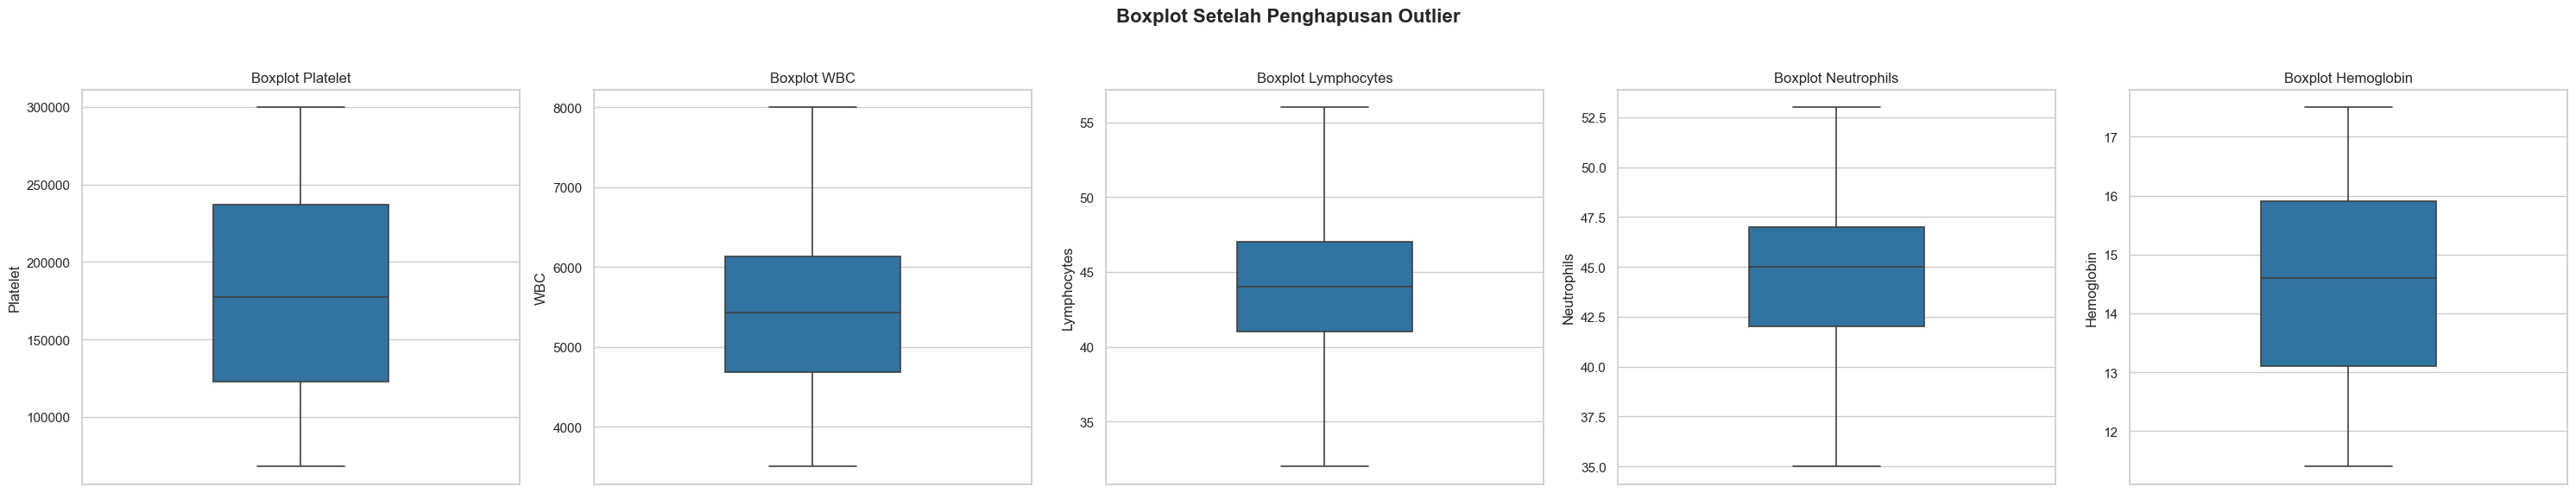

In [712]:
# Daftar fitur yang ingin divisualisasikan (ganti sesuai fitur kamu)
outlier_features = ['Platelet', 'WBC', 'Lymphocytes', 'Neutrophils', 'Hemoglobin']

# Set gaya visual
sns.set(style="whitegrid")

# Buat figure dengan jumlah kolom sesuai jumlah fitur
fig, axes = plt.subplots(nrows=1, ncols=len(outlier_features), figsize=(6 * len(outlier_features), 6))
fig.suptitle('Boxplot Setelah Penghapusan Outlier', fontsize=16, fontweight='bold')

# Warna boxplot
blue_color = '#1f77b4'

# Loop visualisasi setiap fitur
for i, feature in enumerate(outlier_features):
    ax = axes[i] if len(outlier_features) > 1 else axes  # Support untuk 1 atau lebih fitur

    sns.boxplot(
        y=df_cleaned[feature],
        ax=ax,
        color=blue_color,
        fliersize=5,
        linewidth=1.2,
        width=0.4
    )
    ax.set_title(f'Boxplot {feature}', fontsize=12)
    ax.set_ylabel(feature)

# Tata letak dan simpan
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('boxplot_fitur_penting_no_outliers.png', dpi=300)
plt.show()

In [713]:
print("Jumlah data sebelum pembersihan:", df.shape[0])
print("Jumlah data setelah pembersihan:", df_cleaned.shape[0])

Jumlah data sebelum pembersihan: 1228
Jumlah data setelah pembersihan: 1215


In [714]:
df_cleaned['Result'].value_counts()

Result
Ya Dbd       895
Tidak Dbd    320
Name: count, dtype: int64


Distribusi Result:
Result
Ya Dbd       895
Tidak Dbd    320
Name: count, dtype: int64


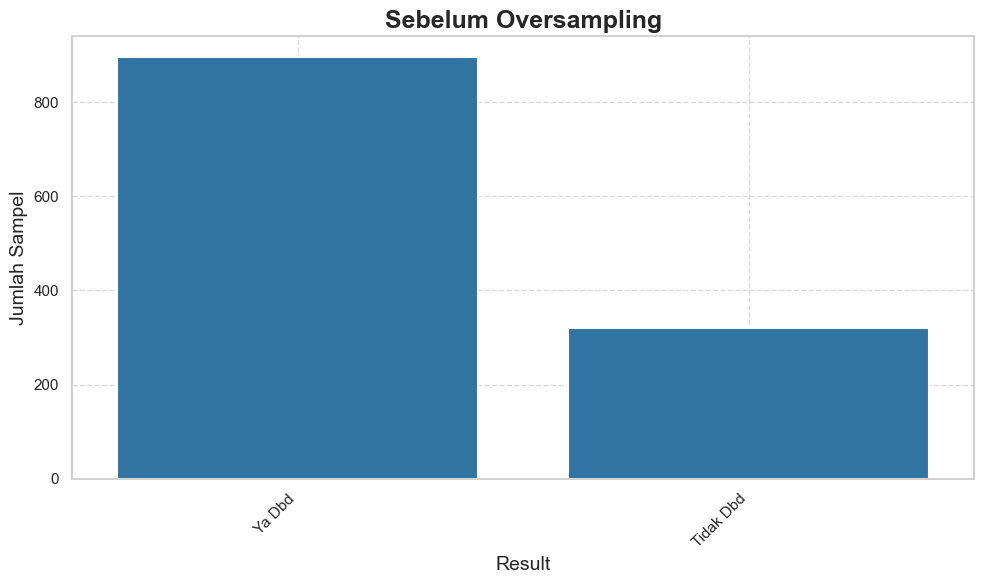

In [716]:
# Cek distribusi Result
print("\nDistribusi Result:")
print(df_cleaned['Result'].value_counts())

# Menyiapkan visualisasi histogram distribusi label dengan jarak antar batang
plt.figure(figsize=(10, 6))

# Menentukan warna biru yang digunakan
blue_color = '#1f77b4'

# Membuat barplot untuk setiap label tanaman dengan jarak antar batang dan warna biru
sns.countplot(x='Result', data=df_cleaned, color=blue_color, linewidth=1.5)

# Menambahkan judul dan label yang lebih informatif
plt.title('Sebelum Oversampling', fontsize=18, fontweight='bold')
plt.xlabel('Result', fontsize=14)
plt.ylabel('Jumlah Sampel', fontsize=14)

# Menambahkan jarak antar batang dengan parameter `width`
plt.xticks(rotation=45, ha='right')  # Menyesuaikan agar nama label tanaman tidak berantakan

# Menampilkan grid untuk mempermudah pembacaan
plt.grid(True, linestyle='--', alpha=0.7)

# Menampilkan plot
plt.savefig('histogramimbalance.png', dpi=300)
plt.tight_layout()
plt.show()


Setelah SMOTE - Distribusi Result:
Result
Ya Dbd       895
Tidak Dbd    895
Name: count, dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_28824\3035513777.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette=['#1f77b4'], linewidth=1.5, width=0.8)
C:\Users\HP\AppData\Local\Temp\ipykernel_28824\3035513777.py:18: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=y_resampled, palette=['#1f77b4'], linewidth=1.5, width=0.8)


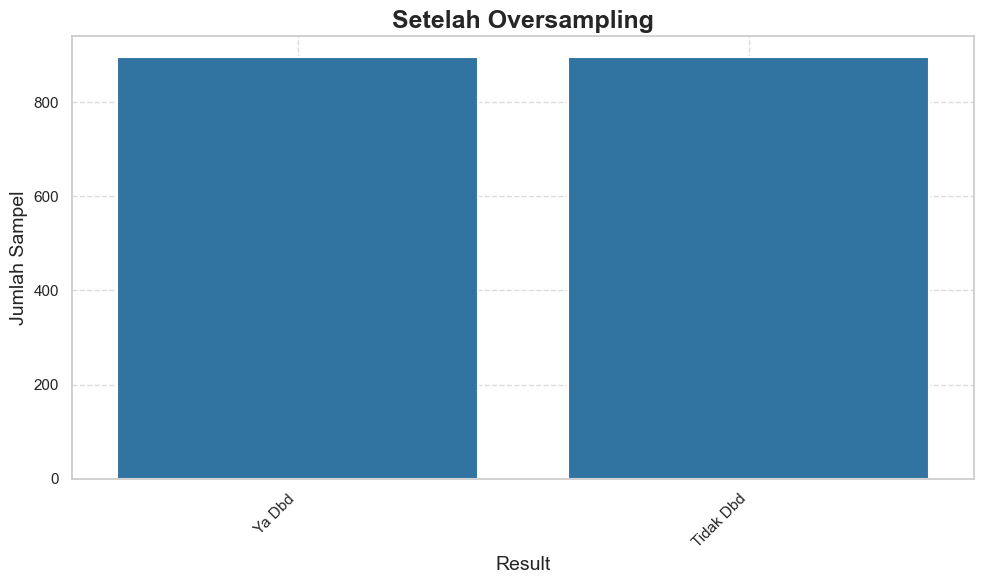

In [717]:
from imblearn.over_sampling import SMOTE

X = df_cleaned.drop('Result', axis=1)
y = df_cleaned['Result']

# Menerapkan SMOTE untuk menangani imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Menampilkan distribusi label setelah SMOTE
print("\nSetelah SMOTE - Distribusi Result:")
print(pd.Series(y_resampled).value_counts())

# Menyiapkan tampilan histogram distribusi label setelah SMOTE
plt.figure(figsize=(10, 6))

# Membuat countplot dengan warna biru yang sama dan jarak antar batang
sns.countplot(x=y_resampled, palette=['#1f77b4'], linewidth=1.5, width=0.8)

# Menambahkan judul dan label yang lebih informatif
plt.title('Setelah Oversampling', fontsize=18, fontweight='bold')
plt.xlabel('Result', fontsize=14)
plt.ylabel('Jumlah Sampel', fontsize=14)

# Menambahkan jarak antar batang dengan parameter `width`
plt.xticks(rotation=45, ha='right')  # Menyesuaikan agar nama label tanaman tidak berantakan

# Menampilkan grid untuk mempermudah pembacaan
plt.grid(True, linestyle='--', alpha=0.7)

# Menampilkan plot
plt.tight_layout()
plt.show()

In [718]:
# Pisahkan fitur dan label dari DataFrame yang sudah dibersihkan
X = df_cleaned.drop('Result', axis=1)
y = df_cleaned['Result']

# Inisialisasi Min-Max Scaler
scaler = MinMaxScaler()

# Lakukan normalisasi pada fitur
X_normalized = scaler.fit_transform(X)

# Konversi kembali ke DataFrame dengan kolom yang sama
X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)

# Gabungkan kembali dengan label (reset index agar sejajar)
df_normalized = pd.concat([X_normalized_df, y.reset_index(drop=True)], axis=1)

# Tampilkan hasil
print("5 Baris Pertama Data Setelah Normalisasi:")
print(df_normalized.head())

print("\n5 Baris Terakhir Data Setelah Normalisasi:")
print(df_normalized.tail())

5 Baris Pertama Data Setelah Normalisasi:
   Platelet       WBC  Lymphocytes  Neutrophils  Hemoglobin     Result
0  0.189816  0.355556     0.625000     0.722222    0.557377     Ya Dbd
1  0.120792  0.222222     0.708333     0.666667    0.590164     Ya Dbd
2  0.500425  0.555556     0.666667     0.333333    0.803279  Tidak Dbd
3  0.427087  0.333333     0.708333     0.611111    0.147541  Tidak Dbd
4  0.375319  0.244444     0.583333     0.555556    0.770492  Tidak Dbd

5 Baris Terakhir Data Setelah Normalisasi:
      Platelet       WBC  Lymphocytes  Neutrophils  Hemoglobin  Result
1210  0.117475  0.710667     0.666667     0.333333    0.950820  Ya Dbd
1211  0.428748  0.487556     0.333333     0.666667    0.885246  Ya Dbd
1212  0.229346  0.335556     0.583333     0.611111    0.737705  Ya Dbd
1213  0.577559  0.503778     0.708333     0.333333    0.295082  Ya Dbd
1214  0.753864  0.583111     0.500000     0.333333    0.295082  Ya Dbd


In [719]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Inisialisasi LabelEncoder
label_encoder = LabelEncoder()

# Lakukan encoding pada kolom 'Label'
df_normalized['Result_Encoded'] = label_encoder.fit_transform(df_normalized['Result'])

# Buat mapping label asli ke hasil encoding
label_mapping = pd.DataFrame({
    'Result Asli': label_encoder.classes_,
    'Result Encode': label_encoder.transform(label_encoder.classes_)
})

# Tampilkan mapping label
print("Mapping Label Asli ke Result Encode:")
print(label_mapping)

# Buat DataFrame final: drop kolom Label asli, ubah 'Label_Encoded' menjadi 'Label'
df_final = df_normalized.drop(columns=['Result']).rename(columns={'Result_Encoded': 'Result'})

Mapping Label Asli ke Result Encode:
  Result Asli  Result Encode
0   Tidak Dbd              0
1      Ya Dbd              1


In [720]:
# Simpan scaler ke file
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print("Scaler berhasil disimpan sebagai 'scaler.pkl'")

Scaler berhasil disimpan sebagai 'scaler.pkl'
